In [9]:
# Беру завершенные заказы по пользователям, при этом заказ должен быть один

unique_id.loc[unique_id['order_status'] == 'delivered'] \
    .groupby('customer_unique_id',as_index=False) \
    .agg({'order_id':'count'}) \
    .query('order_id == 1') \
    .count().order_id

90556

Получаю ответ: 90556.
    
То есть 90556 пользователей совершили покупку только один раз.

## Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [10]:
# Сначала нужно проверить таблицу на наличие дублей в колонке статуса заказа

olist_orders.groupby('order_id', as_index=False)\
    .agg({'order_status':'count'}) \
    .order_status.unique() 

array([1], dtype=int64)

In [11]:
# Проверяю типы колонок в таблице

olist_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [12]:
# Привожу колонку к формату datetime

olist_orders.order_purchase_timestamp = pd.to_datetime(olist_orders.order_purchase_timestamp) 

In [13]:
# Проверяю еще раз

olist_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
dtype: object

In [14]:
# Ищеу среднее в недоставленных заказах

avg_cancel_orders = olist_orders.query('order_status != "delivered"')\
    .groupby([pd.Grouper(freq='MS', key='order_purchase_timestamp'),'order_status'],as_index=False) \
    .agg({'order_id':'count'}) \
    .groupby('order_status',as_index=False)\
    .agg({'order_id':'mean'}) \
    .rename(columns={'order_id':'avg_value'})

In [15]:
# Вывожу полученную таблицу

avg_cancel_orders

,order_status,avg_value
0,approved,1.000000
1,canceled,26.041667
2,created,1.666667
3,invoiced,14.952381
4,processing,15.842105
5,shipped,48.130435
6,unavailable,29.000000


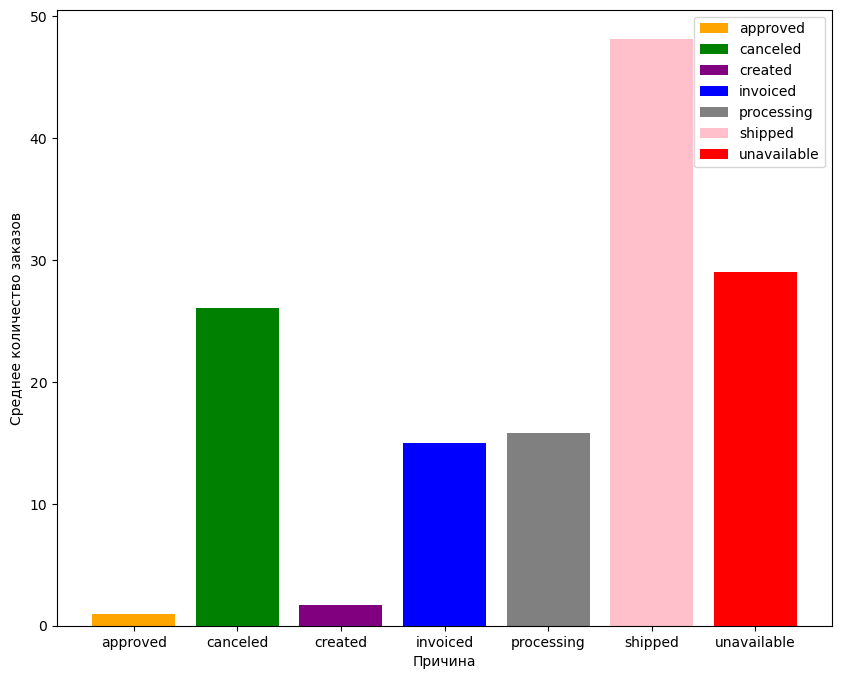

In [16]:
# Создаю цвета в графике
colors = {
    'canceled': 'green',
    'unavailable': 'red',
    'invoiced': 'blue',
    'created': 'purple',
    'approved': 'orange',
    'processing': 'gray',
    'shipped': 'pink',
}

# Строю диаграмму
fig, ax = plt.subplots(figsize=(10,8))
for i in range(len(avg_cancel_orders)):
    status = avg_cancel_orders['order_status'][i]
    value = avg_cancel_orders['avg_value'][i]
    color = colors[status]
    ax.bar(status, value, color=color, label=status)

ax.set_xlabel('Причина')
ax.set_ylabel('Среднее количество заказов')
ax.legend()

plt.show()

Детализация по причинам:

больше всего отменено покупок из-за ошибки сервиса доставки (shipped) - 48,13% 
на втором месте (approved, created, invoiced, canceled) - отмена заказа на разных этапах заказчиком - 42,66%
далее - это причина отсутствия товара (unavailable) - 29%
и системный сбой (processing) - 15,84%.